# Groen, groener, groenst
Voor iedere buurt in Breda surface temperature-data ophalen vanuit Earth Engine (blijkbaar iets heftiger dan NDVI), periode 2010 tot 2020, [MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1), 250x250 meter.

In [10]:
import ee
import datetime
import geopandas as gpd
import pandas as pd
import numpy as np

In [5]:
def get_stemp(start_date, end_date):
    '''to get surface temp data for breda, given start_date & end_date, returns image collection from start to end, filetered by aoi, only surface temp-band'''
    # init the ee object
    ee.Initialize()

    # define the area of interest
    breda = gpd.read_file('data/shape/breda.shp')
    breda = breda.to_crs(epsg=4326) # to lat-lon
    breda = breda.loc[0, 'geometry'].__geo_interface__
    AOI = ee.Geometry.Polygon(breda['coordinates'])

    # start - end date
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)

    # return image collection
    return ee.ImageCollection('MODIS/006/MOD11A1').filterDate(start_date, end_date).filterBounds(AOI).select('LST_Day_1km')   

In [6]:
def to_dataframe(row):
    '''make dataframe containing mean surface temp for buurt, given row from geodataframe'''
    geometry = row['geometry'].__geo_interface__['coordinates'] # get coordinate list
    stempbuurt = stemp.getRegion(ee.Geometry.Polygon(geometry), 100).getInfo() # get points in geometry
    header = stempbuurt[0]
    data = np.array(stempbuurt[1:])

    time = [datetime.datetime.fromtimestamp(int(i)/1000) for i in data[0:,header.index('time')]] # convert timestamps
    values = data[0:,header.index('LST_Day_1km')] # evi-values
    return pd.DataFrame(values, index=time, columns=[row['BU_NAAM']]).astype(float).resample('d').mean()

In [11]:
# load breda buurten
buurten = gpd.read_file('data/shape/breda_buurten.shp')
buurten = buurten.to_crs(epsg=4326) # to lat-lon

# get average EVI for each buurt in one dataframe cols -> buurt
data = pd.DataFrame()
for year in range(2000,2020): # split up in one year at a time, to not overload api
    print('{}-{} => 2020'.format(year, year + 1))
    # get ndvi for given period
    stemp = get_stemp(start_date='{}-01-01'.format(year), end_date='{}-01-01'.format(year + 1))

    cols = pd.DataFrame()
    for i, row in buurten.iterrows():
        df = to_dataframe(row)
        cols = pd.concat([cols, df], axis=1)
        print('{}/{}'.format(i+1, len(buurten)), end='\r')
    data = pd.concat([data, cols], axis=0)
data.to_csv('data/satdata/stemp.csv')

2000-2001 => 2020
2001-2002 => 2020
2002-2003 => 2020
2003-2004 => 2020
2004-2005 => 2020
2005-2006 => 2020
2006-2007 => 2020
2007-2008 => 2020
2008-2009 => 2020
2009-2010 => 2020
2010-2011 => 2020
2011-2012 => 2020
2012-2013 => 2020
2013-2014 => 2020
2014-2015 => 2020
2015-2016 => 2020
2016-2017 => 2020
2017-2018 => 2020
2018-2019 => 2020
2019-2020 => 2020


In [12]:
data.groupby(data.index.year).describe()

Valkenberg                                                        \
          count          mean         std           min           25%   
2000       78.0  14708.311488  511.158234  13537.179104  14381.462687   
2001       93.0  14517.745069  614.733369  13320.000000  14053.402985   
2002      116.0  14585.149838  523.682722  13551.134328  14178.902985   
2003      153.0  14619.643197  584.511170  12782.000000  14126.985075   
2004      118.0  14574.363872  523.283775  12530.274510  14143.358209   
2005      118.0  14619.692697  562.267797  13445.078431  14095.671297   
2006      128.0  14673.570820  620.235408  13622.940299  14149.988806   
2007      124.0  14581.165309  477.247017  13542.955224  14170.416667   
2008      125.0  14540.524845  524.809631  13597.268657  14106.000000   
2009      122.0  14580.455240  573.455530  12970.000000  14190.324627   
2010      111.0  14526.231403  716.880437  12727.000000  13978.925373   
2011      130.0  14610.110502  496.013286  13693.761194  14159.455224   
2012      120.0  14553.620771  569.630345  13186.910448  14125.271510   
2013      106.0  14606.100886  587.350823  13394.850746  14101.083333   
2014      125.0  14631.035815  435.934818  13466.417910  14323.253731   
2015      126.0  14590.556243  525.820992  12920.000000  14119.182836   
2016      123.0  14611.271419  550.200079  13539.666667  14075.485075   
2017      111.0  14624.328295  568.587233  13349.268657  14181.291045   
2018      145.0  14764.991837  607.165300  13623.910448  14262.074627   
2019      134.0  14652.846477  525.550235  13393.507463  14183.149254   

                                               ChassÃ©                ...  \
               50%           75%           max   count          mean  ...   
2000  14699.723881  15130.988806  15678.731343    81.0  14675.129991  ...   
2001  14515.000000  15070.865672  15610.238806    95.0  14518.057056  ...   
2002  14565.910448  14974.115672  15607.537313   114.0  14573.376183  ...   
2003  14621.477612  15092.567164  15653.552239   159.0  14590.147735  ...   
2004  14658.828358  14989.544776  15429.223881   120.0  14570.122327  ...   
2005  14730.500000  15046.649254  15743.253731   125.0  14601.209717  ...   
2006  14666.492537  15245.018657  15893.850746   120.0  14671.251845  ...   
2007  14615.298507  14924.329602  15514.149254   126.0  14566.245317  ...   
2008  14536.400000  14956.895522  15562.328358   121.0  14542.492096  ...   
2009  14737.877727  14973.223881  15477.462687   129.0  14580.519668  ...   
2010  14700.746269  15107.850746  15710.746269   115.0  14506.919013  ...   
2011  14658.276119  15005.962687  15527.791045   129.0  14592.714009  ...   
2012  14618.656716  15022.970149  15536.388060   120.0  14573.013159  ...   
2013  14639.470149  15084.503731  15769.537313   114.0  14586.393814  ...   
2014  14664.283582  14937.880597  15492.462687   125.0  14635.488729  ...   
2015  14604.573603  14953.791045  15694.223881   132.0  14584.580563  ...   
2016  14603.746269  15095.469271  15623.761194   131.0  14597.723462  ...   
2017  14678.328358  15106.925373  15662.164179   111.0  14589.227725  ...   
2018  14829.850746  15278.895522  15856.074627   142.0  14752.927979  ...   
2019  14664.888060  15086.500000  15668.940299   137.0  14632.963579  ...   

       Vuchtpolder               Buitengebied Teteringen                \
               75%           max                   count          mean   
2000  14849.317245  15409.120390                    95.0  14512.184070   
2001  14739.016908  15370.495662                   111.0  14379.486815   
2002  14800.261659  15277.147505                   129.0  14484.378978   
2003  14969.868492  15368.733189                   156.0  14511.603219   
2004  14794.146155  15227.826990                   125.0  14460.717819   
2005  14818.235272  15496.788503                   122.0  14527.054614   
2006  14995.858779  15594.597614                   132.0  14553.587833   
2007  14753.238781  15345.769231     

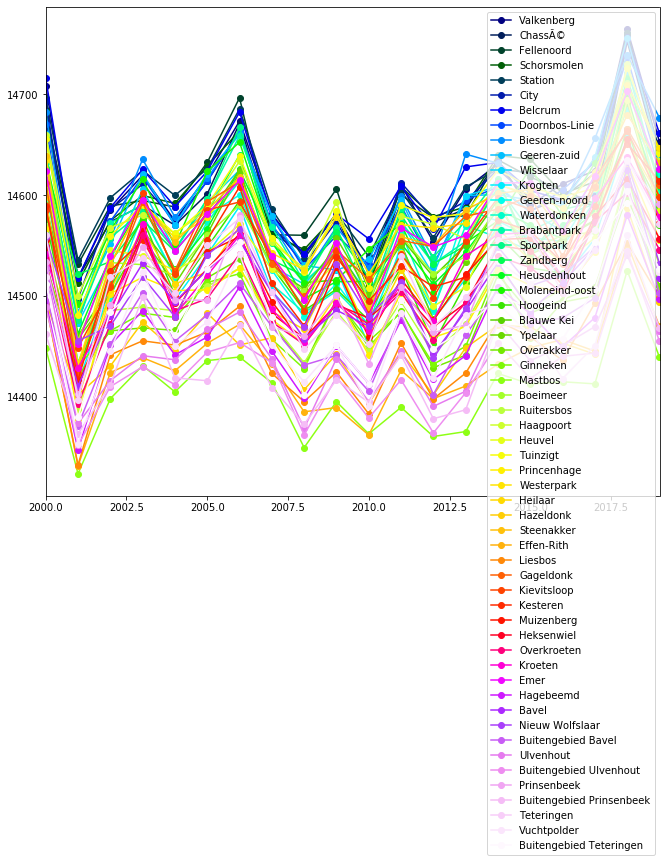

In [13]:
data.groupby(data.index.year).mean().plot(figsize=(11,9), style='-o', cmap='gist_ncar')

2000          AxesSubplot(0.1,0.77069;0.173913x0.12931)
2001     AxesSubplot(0.308696,0.77069;0.173913x0.12931)
2002     AxesSubplot(0.517391,0.77069;0.173913x0.12931)
2003     AxesSubplot(0.726087,0.77069;0.173913x0.12931)
2004         AxesSubplot(0.1,0.615517;0.173913x0.12931)
2005    AxesSubplot(0.308696,0.615517;0.173913x0.12931)
2006    AxesSubplot(0.517391,0.615517;0.173913x0.12931)
2007    AxesSubplot(0.726087,0.615517;0.173913x0.12931)
2008         AxesSubplot(0.1,0.460345;0.173913x0.12931)
2009    AxesSubplot(0.308696,0.460345;0.173913x0.12931)
2010    AxesSubplot(0.517391,0.460345;0.173913x0.12931)
2011    AxesSubplot(0.726087,0.460345;0.173913x0.12931)
2012         AxesSubplot(0.1,0.305172;0.173913x0.12931)
2013    AxesSubplot(0.308696,0.305172;0.173913x0.12931)
2014    AxesSubplot(0.517391,0.305172;0.173913x0.12931)
2015    AxesSubplot(0.726087,0.305172;0.173913x0.12931)
2016             AxesSubplot(0.1,0.15;0.173913x0.12931)
2017        AxesSubplot(0.308696,0.15;0.173913x0

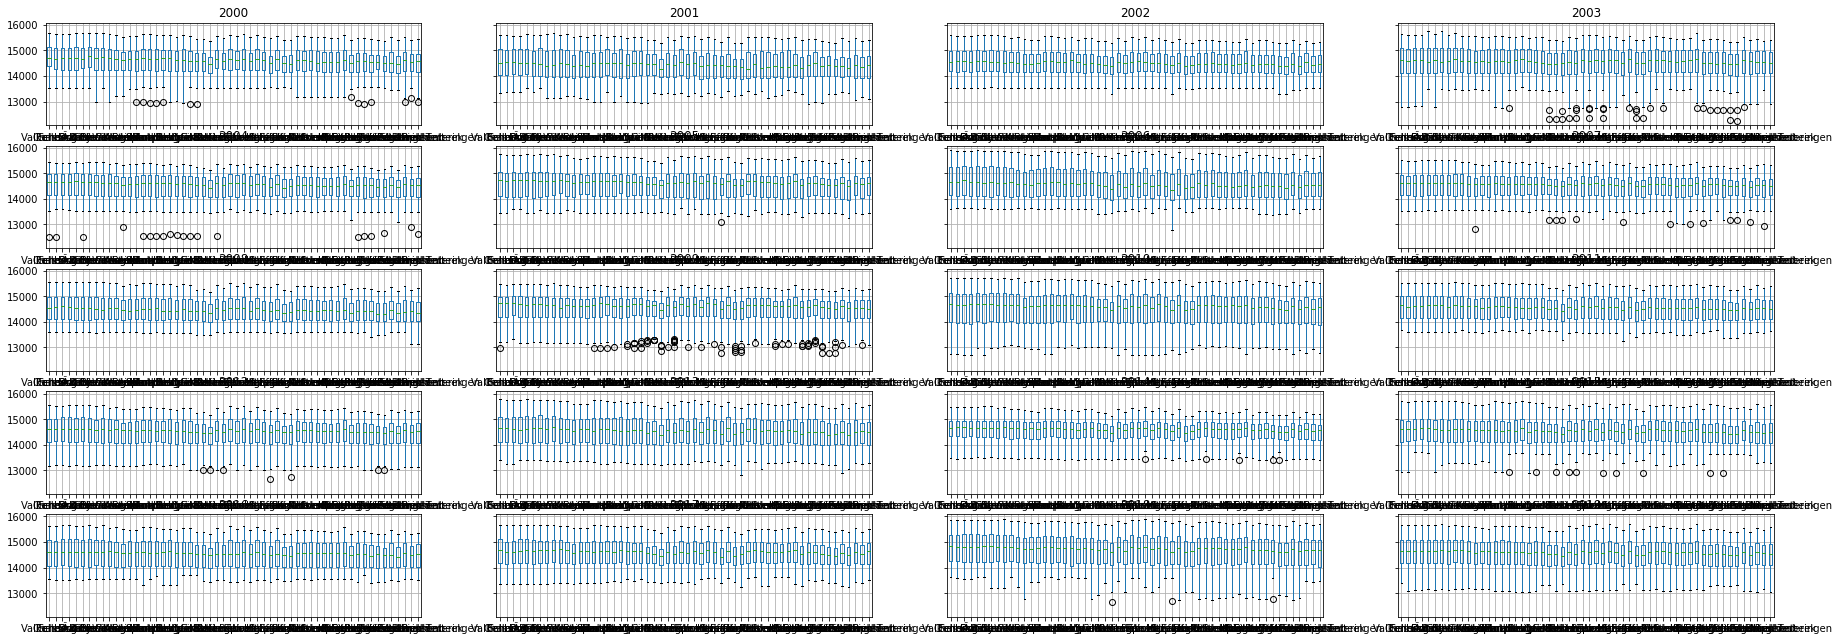

In [14]:
data.groupby(data.index.year).boxplot(figsize=(30,11))

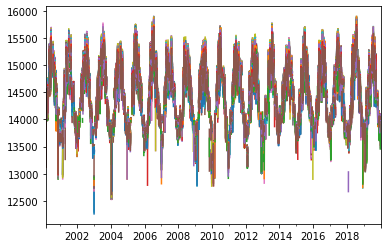

In [15]:
data.plot(legend=False)